In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Hello World
This tutorial/example aims to give an simplistic overview of setting up a passive volume (scattering material to be imaged), detector (active material to record hits), and optimisation loop (to refine the detector to image the passive volume better or more cheaply)

## Volume setup
The volume consists of both passive material to be imaged, and active detectors to record muons hits. We aim to adjust the position and xy-span of the detectors to minimise the cost of the detector whilst improving the precision of the imaging of the passive volume.

<img src="imgs/panel detector.png" width="256">

The above image shows a typical layout, with multiple detection layers above and below the passive volume consisting of layers of material. Each passive layer consists of sub-cubes (voxels, these can be different materials, whose X0 will affect the scattering of muons to deferring extents.. In the detector layers, there can be multiple panels with fixed resolution and efficiency. The xyz position of the panels and their xy extent are the properties to be optimised.

In [2]:
from tomopt.core import *

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch import Tensor
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
DEVICE = torch.device('cpu')

Construct a volume by sandwiching passive layers with pairs of detector layers above and below. Detector panels are initialised with specified parameters, but the number of detector panels per layer is fixed. Passive layers will contain voxels of different materials.

In [5]:
import numpy as np
from torch import nn
from tomopt.volume import PassiveLayer, PanelDetectorLayer, DetectorPanel

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.9
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.25,0.25,1-(i*(2*size)/n_panels)], init_xy_span=[1.0, 1.0],
                                                      device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.25,0.25,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0, 1.0],
                                                      device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

We'll feed these stacked layers into a single object for convenience.

In [7]:
from tomopt.volume import Volume

In [8]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.2500, 0.2500]), z=tensor([1.]), and xy span tensor([1., 1.]) with budget scale tensor([1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.2500, 0.2500]), z=tensor([0.9500]), and xy span tensor([1., 1.]) with budget scale tensor([1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.2500, 0.2500]), z=tensor([0.9000]), and xy span tensor([1., 1.]) with budget scale tensor([1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.2500, 0.2500]), z=tensor([0.8500]), and xy span tensor([1., 1.]) with budget scale tensor([1.])
      )
    )
    (1): PassiveLayer located at z=tensor([0.8000])
    (2): PassiveLayer located at z=tensor([0.7000])
    (3): PassiveLayer located at z=tensor([0.6000])
    (4): PassiveLayer located at z=te

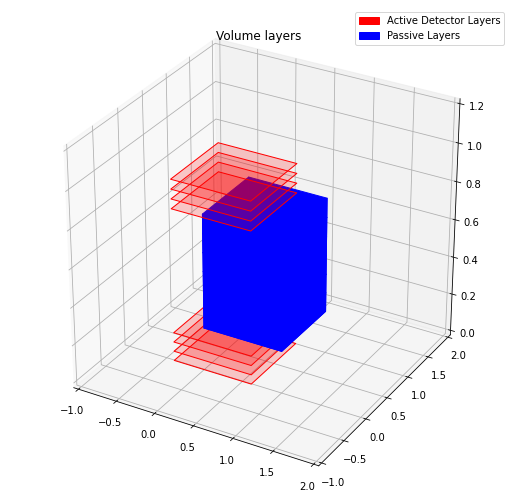

In [9]:
# Uncomment magic lines if you want an interactive plot that you need to rotate
# %matplotlib notebook
volume.draw(xlim=(-1,2), ylim=(-1,2), zlim=(0, 1.2))
# %matplotlib inline

In [10]:
volume.get_cost()

tensor(8., grad_fn=<AddBackward0>)

## Optimisation

Having built our detector and defined where the passive volumes will be, we now want to define the material composition of the passive volume(s) to be imaged, and to optimise our detector.
As its name suggests, `PanelVolumeWrapper` wraps the `Volume` and provides methods to optimise the detector, predict passive volumes, loading and saving of detector configurations, etc.

When building the wrapper, we need to supply it with optimiser definitions for both resolution and efficiency, and a loss function to optimise. Optimisers are the classes in PyTorch which implement gradient descent on specified parameters. For the optimisers, use partial definitions, since the `PanelVolumeWrapper` takes care of instantiating the optimisers to relate to the relevant detector parameters. Although we set some learning rates (`lr`) here, it is difficult to know a priori what are suitable values. When running the optimisation, though, we will use a special callback to set more suitable values.

In [11]:
from functools import partial
from tomopt.optimisation import PanelVolumeWrapper, VoxelX0Loss

In [12]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))  # Loss is precision + budget_coef*cost_coef, balance coef as required or leave as None to automatically balance on first batch

Now we need to define the composition of the passive volume. This is done via a function which is called per passive layer (we have six) and returns the x0 (radiation length [m]) of the material in the voxels in that layer. Below we'll define the passive material to be mostly beryllium but with a single block of lead in the corner of one of the layers.

In [13]:
from tomopt.core import X0

In [14]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

Since we may want to optimise the detector for multiple different passive volumes (or randomly generated volumes), different functions can be passed to the `PanelVolumeWrapper` during optimisation by loading the functions into `PassiveYielder` objects, which loop through the passive volumes. In this tutorial, though, we only have one passive volume.

In [15]:
from tomopt.optimisation import PassiveYielder

In [16]:
passives = PassiveYielder([arb_rad_length])

Now we're in a position to optimise our detector using the `VolumeWrapper.fit` method. The general layout for the optimisation loop is as follows, where `mu_bs` is the number of muons passed through the volume simultaneously and `passive_bs` is the number of passive volumes used per detector update:
1. for epoch in `n_epochs`:
    1. `loss` = 0
    1. for `p`, `passive` in enumerate(`trn_passives`):
        1. load `passive` into passive volume
        1. for muon_batch in range(`n_mu_per_volume`//`mu_bs`):
            1. Irradiate volume with `mu_bs` muons
            1. Infer passive volume
        1. Compute loss based on precision and cost, and add to `loss`
        1. if `p`+1 % `passive_bs` == 0:
            1. `loss` = `loss`/`passive_bs`
            1. Backpropagate `loss` and update detector parameters
            1. `loss` = 0
        1. if len(`trn_passives`)-(`p`+1) < `passive_bs`:
            1. Break
            
    1. `val_loss` = 0
    1. for `p`, `passive` in enumerate(`val_passives`):
        1. load `passive` into passive volume
        1. for muon_batch in range(`n_mu_per_volume`//`mu_bs`):
            1. Irradiate volume with `mu_bs` muons
            1. Infer passive volume
            1. Compute loss based on precision and cost, and add to `val_loss`
        1. if len(`val_passives`)-(`p`+1) < `passive_bs`:
            1. Break
    1. `val_loss` = `val_loss`/`p`

I.e. the loss for a single passive can be computed over several iterations of muon irradiation (for computational speed), and the total loss can be accumulated over multiple passives before updating the detector. In our case we only have one passive. We also have the option of evaluating the detector on unseen passives via validation data. For this example, we'll use the same passive for the both training and validation.

Additionally, the optimisation loop has many interjection points for callback classes, which can affect most aspects of the optimisation. A few of the recommended callbacks are listed below:

- `NoMoreNaNs`: Currently in TomOpt, there is a problem which means that sometimes the gradients for some parameters are `NaN` after backpropagation. The `tomopt.optimisation.callbacks.grad_callbacks.NoMoreNaNs` will automatically go through each parameter after backpropagation and replace `NaN` gradients with zeros prior to the optimiser update step.
- `PanelMetricLogger`: It is useful to have an indication of the progress the optimisation, and the current state of the detector. `tomopt.optimisation.callbacks.monitors.MetricLogger` provides real-time progress updates and telemetric data.
- `CostCoefWarmup`: The loss contains a coefficient which is used to balance the error and cost components. This can be set manually or automatically. The loss contains a method to set the coefficient automatically, but it does so using the first volume tested, and so is subject to fluctuations. `tomopt.optimisation.callbacks.loss_callbacks.CostCoefWarmup` is a callback which will run a specified number of warm-up epochs during which the detectors will not be optimised, and instead a more stable cost coefficient will be computed.
- `OptConfig`: A recent addition is the `tomopt.optimisation.callbacks.opt_callbacks.OptConfig` callback. Like the `CostCoefWarmup` it uses a warm-up period to track the gradients received by the detector parameters. The user can then instead specify their desired rate of change rate in physical units, and the learning rates of the optimisers will be overwritten to achieve the specified rates.
- `MuonResampler`: When optimising the detectors, we only want to consider muons which pass through the passive volume, however not all muons are guaranteed to do so. The `tomopt.optimisation.callbacks.data_callbacks.MuonResampler` will automatically regenerate muons which will not pass through the passive volume. Since this relies on "truth" information in the generator, this should not be used for realistic simulations.
- `PanelUpdateLimiter` limits the maximum amount that detector parameters can change in a single update. Like gradient clamping, this can be used to mitigate the effects of anomalous spikes in loss/gradient pushing the mdoe into a region of poor performance.

In [18]:
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup, OptConfig, MuonResampler, PanelUpdateLimiter

2 warmup callbacks found, with a total warmup period of 10 epochs.


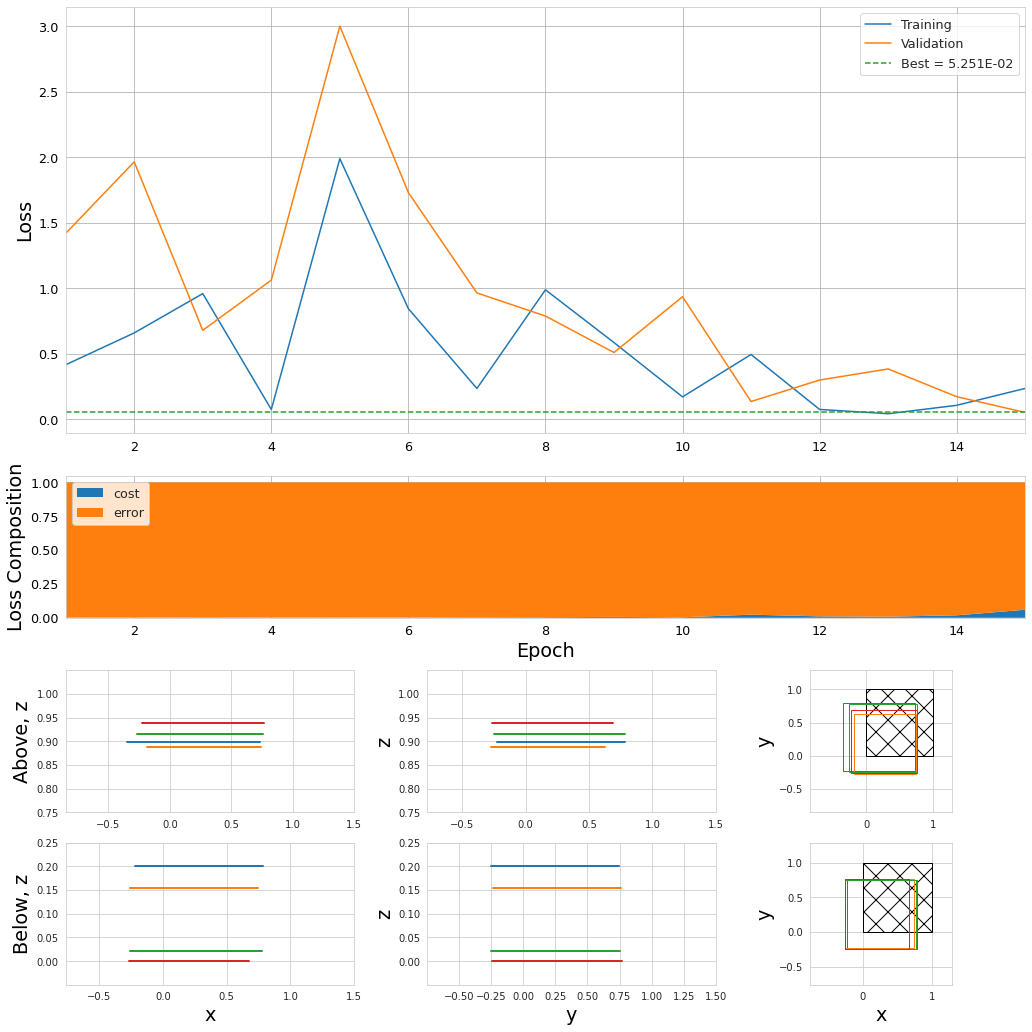

/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:219: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


CostCoefWarmup: Warmed up, average error = 0.6577121615409851
OptConfig: Optimiser warm-up completed
+-------------+-------------+------------------------+
|    Param    | Median Grad |           LR           |
+-------------+-------------+------------------------+
|  xy_pos_opt |  1.8608152  |  0.005373988870601767  |
|  z_pos_opt  |   611.6209  | 1.6349996911423315e-05 |
| xy_span_opt |  0.3681875  |  0.02716007563992585   |
+-------------+-------------+------------------------+


<Figure size 1024x1024 with 0 Axes>

In [30]:
_ = wrapper.fit(n_epochs=15,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=250,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefWarmup(n_warmup=5),
                     OptConfig(n_warmup=5, rates={'xy_pos_opt':0.01, 'z_pos_opt':0.01, 'xy_span_opt':0.01}),
                     MuonResampler(),
                     NoMoreNaNs(),
                     PanelUpdateLimiter(max_xy_step=(0.2, 0.2), max_xy_span_step=(0.2, 0.2), max_z_step=0.1),
                     PanelMetricLogger()])

In [31]:
volume.get_cost()
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.1927, 0.2786]), z=tensor([0.8993]), and xy span tensor([1.0820, 1.0164]) with budget scale tensor([1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.2760, 0.1745]), z=tensor([0.8877]), and xy span tensor([0.9254, 0.9005]) with budget scale tensor([1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.2459, 0.2656]), z=tensor([0.9145]), and xy span tensor([1.0211, 1.0309]) with budget scale tensor([1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.2694, 0.2133]), z=tensor([0.9378]), and xy span tensor([0.9961, 0.9493]) with budget scale tensor([1.])
      )
    )
    (1): PassiveLayer located at z=tensor([0.8000])
    (2): PassiveLayer located at z=tensor([0.7000])
    (3): PassiveLayer located at z=tensor([0.6000])
 

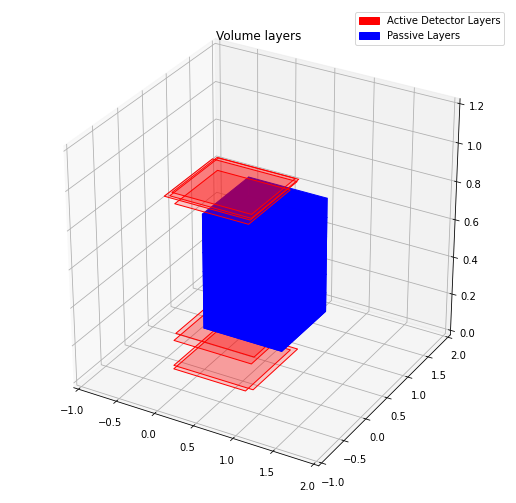

In [32]:
# Uncomment magic lines if you want an interactive plot that you need to rotate
# %matplotlib notebook
volume.draw(xlim=(-1,2), ylim=(-1,2), zlim=(0.0, 1.2))
# %matplotlib inline


## Predictions
`VolumeWrapper` also has a `.predict` method to provide predictions per passive volume. For convenience it also returns the true material composition for each prediction. We'll include the `MuonResampler` under the assumption that we have a trigger/classifier that rejects muons that miss the passive volume.

In [33]:
preds = wrapper.predict(passives,
                        n_mu_per_volume=10000,
                        mu_bs=100,
                        cbs=[MuonResampler()])

`preds` is a list of tuples of predicted x0 and true x0 per passive volume. We can plot these with `tomopt.plotting.predictions.plot_pred_true_x0`.

In [34]:
from tomopt.plotting import plot_pred_true_x0

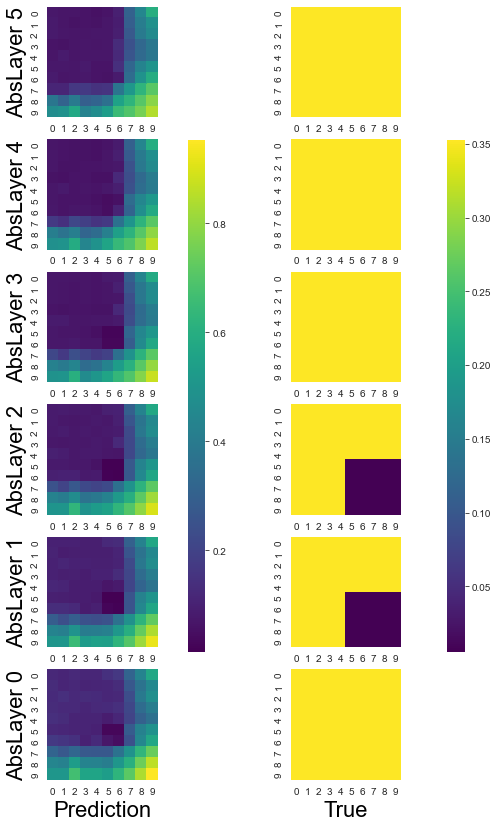

In [35]:
plot_pred_true_x0(*preds[0])

Above we have the predicted and true x0 for ever voxel in the six passive layers. Currently the predictions are quite poor, due to biases in the prediction method.